In [ ]:
pip install pyspark

In [ ]:
pip install findspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("PCA_LR").getOrCreate()

# Load dataset
data_path = "/content/diabetes.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Assemble features
feature_cols = [col for col in df.columns if col != 'Outcome']  # Assuming 'Outcome' is the target column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "Outcome")

# Train-test split
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Outcome")
lr_model = lr.fit(train)

# Evaluate before PCA
predictions = lr_model.transform(test)
evaluator = RegressionEvaluator(labelCol="Outcome", metricName="r2")
r2_before = evaluator.evaluate(predictions)

# Apply PCA
pca = PCA(k=5, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_data = pca_model.transform(data).select("pca_features", "Outcome")
train_pca, test_pca = pca_data.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression on PCA-transformed data
lr_pca = LinearRegression(featuresCol="pca_features", labelCol="Outcome")
lr_pca_model = lr_pca.fit(train_pca)

# Evaluate after PCA
predictions_pca = lr_pca_model.transform(test_pca)
r2_after = evaluator.evaluate(predictions_pca)

# Print results
print(f"accuracy Before PCA: {r2_before}")
print(f"accuracy After PCA: {r2_after}")

# Stop Spark Session
spark.stop()

accuracy Before PCA: 0.37376562990901774
accuracy After PCA: 0.23274531884416316


Dataset Overview:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000

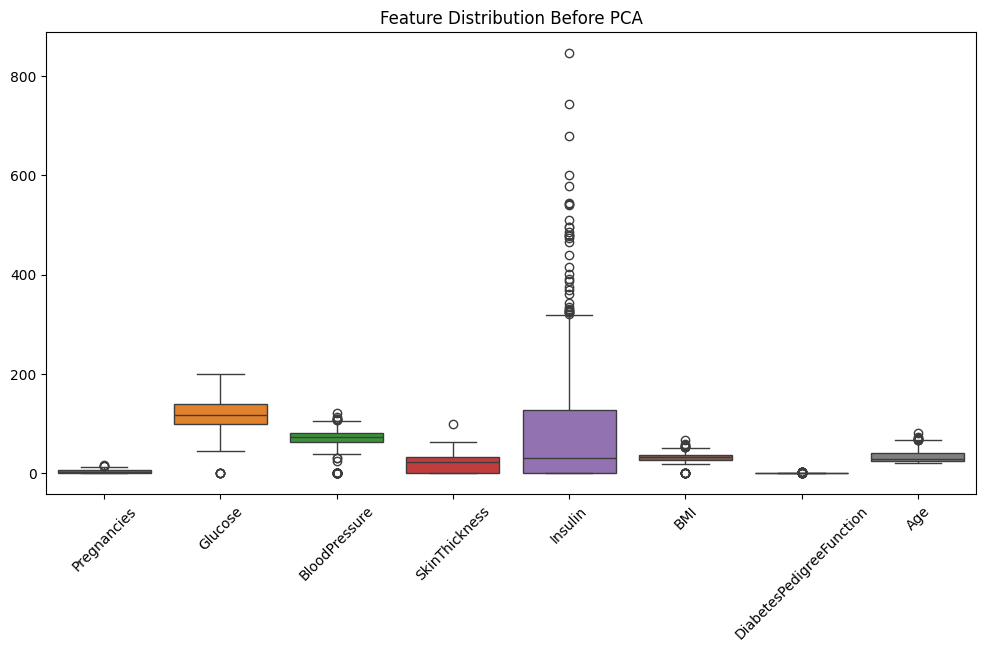

Accuracy Before PCA: 0.75


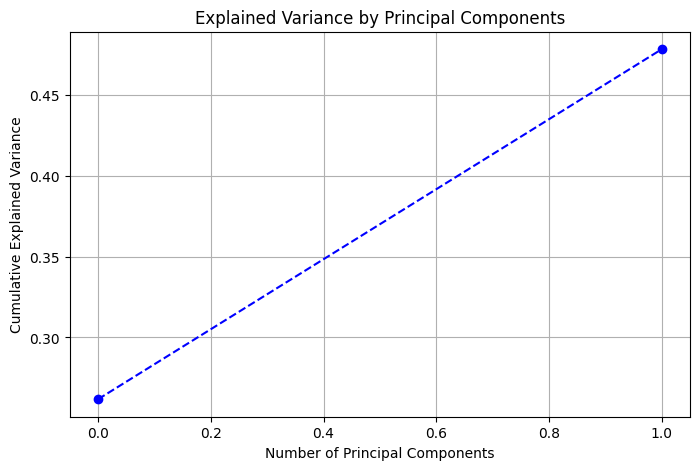

Accuracy After PCA: 0.71


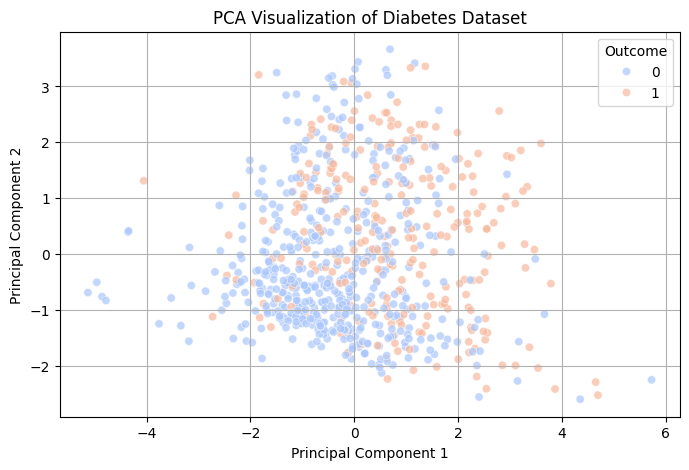

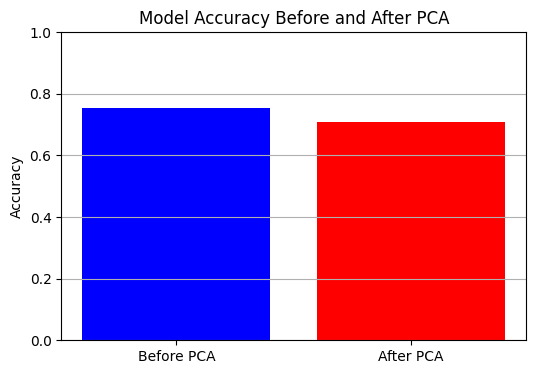

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler, PCA as SparkPCA
from pyspark.ml.classification import LogisticRegression as SparkLR
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load dataset
file_path = "/content/diabetes.csv"
df = pd.read_csv(file_path)

# Basic Analysis Before PCA
print("Dataset Overview:")
print(df.describe())
print("Missing Values:")
print(df.isnull().sum())

# Feature distribution before PCA
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=['Outcome']))
plt.title("Feature Distribution Before PCA")
plt.xticks(rotation=45)
plt.show()

# Separating features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data before PCA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Training Logistic Regression before PCA
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_before_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy Before PCA: {accuracy_before_pca:.2f}")

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Train Logistic Regression after PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = lr_pca.predict(X_test_pca)
accuracy_after_pca = accuracy_score(y_test_pca, y_pred_pca)
print(f"Accuracy After PCA: {accuracy_after_pca:.2f}")

# PCA component visualization
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Diabetes Dataset")
plt.legend(title="Outcome")
plt.grid()
plt.show()

# Accuracy comparison bar chart
plt.figure(figsize=(6, 4))
plt.bar(["Before PCA", "After PCA"], [accuracy_before_pca, accuracy_after_pca], color=['blue', 'red'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Before and After PCA")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()